# Linear Regression and parameter estimation in different ways

Linear regression is one of the simplest machine learning models out there. 
According to its simplicity its maybe overhead to call it "machine learning, but I think its a good starting point try work with different algorithms to estimate the parameters.

In this notebook I will explore the foundation of linear regression and implement different methods of training a regression model on linear data:

1. [Simple linear regression](#1.-Simple-linear-regression)
2. [Ordinary least squares (OLS)](#2.-Ordinary-least-squares-regression)
3. [Gradient descent](#3.-Gradient-descent-optimization)
4. [Metropolis-Hastings MCMC](#4.-Markov-Chain-Monte-Carlo-parameter-estimation)
5. [Linear Regression with Keras and Tensorflow](#5.-Linear-Regression-with-Keras-and-Tensorflow)

We'll start of by describing the problem of linear regression and the toy data we'll use, followed by implementations of all methods mentioned above.

In [1]:
# Necessary import for the functions below
%matplotlib inline

import sys
import warnings
import numpy as np
from numpy import log, exp, sqrt, pi, e

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormaps
import seaborn as sns
import tqdm

sns.set_style('darkgrid')
warnings.simplefilter(action='ignore', category=FutureWarning)
#

# Plotting functions
def plot_linear_regression(x,y,theta_0, theta_1,title,ax=None):
    ''' Plot linear regression scatter datapoints and line based on estimated theta'''
    # Show data
    if ax is None:
        plt.figure(figsize=(10, 5))
        ax = plt.gcf().gca()
        
    #plt.figure(figsize=(6, 4))
    ax.scatter(x, y, c='magenta',label='data: $(x,y)$')
    # plot linear regression line between dependend x and indepependet y
    ax.plot(
        x, x*theta_1+theta_0, '-', 
        label=f'$y = {theta_0:.2f} + {theta_1:.2f} x$')
    #ax.set_xlim((min(x), max(x)))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(title)
    ax.legend()

## Linear regression problem description

[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression)/[Einfache_lineare_Regression](https://de.wikipedia.org/wiki/Einfache_lineare_Regression) will try to fit a linear relationship (straight line) between an [independent variable](https://en.wikipedia.org/wiki/Dependent_and_independent_variables) $x$ (input) and an [dependent variable](https://en.wikipedia.org/wiki/Dependent_and_independent_variables) $y$ (output). 

For $n$ data samples the assumed linear relationship can be modelled as:

$$
y_i = \theta_0 + \theta_1 x_i + \epsilon_i  \quad (i = 1, \ldots, n)
$$

*Hint* In contrast to linear regression, [polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression) is a form of regression analysis in which the relationship between the independent variable x and the dependent variable y is modelled as an nth degree polynomial in x:

$$
y_i = \theta_0 + \theta_1 x_i + \theta_2 {x_i}^2 + \cdots + \theta_m {x_i}^m +\epsilon_i  \quad (i = 1, \ldots, n)
$$

With:
- $x_i$ the independent (input) variable of sample $i$, with $x = \{x_i \ldots x_n \}$.
- $y_i$ the dependent (output) variable of sample $i$, with $y = \{y_i \ldots y_n \}$.
- $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ [Gaussian noise](https://en.wikipedia.org/wiki/Normal_distribution) affecting the output $y_i$.
- $\theta = \{\theta_0, \theta_1 \}$ the set of the parameters we want to optimize:
    - $\theta_0$ the intercept of the model (bias)
    - $\theta_1$ the coefficient of variable $x$ (slope)

We can use this discription to define our toy data sample for linear regression:

In [537]:
# Functions for creating the datasets
def f(X, theta_0,theta_1, std):
    
    '''Linear regression function plus noise'''
    try:
        #return theta_0 + theta_1 * X + epsilon(X.shape, std)
        return np.asarray(np.random.normal(theta_1*X+theta_0,np.abs(X)*std),dtype=np.float32)
    except:
        print("Without noise")
        return theta_0 + theta_1 * X
    
# Function for creating random noise
def epsilon(size, std):
    '''Random normal distributed noise'''
    mu = 0
    sigma = std
    return np.random.normal(loc=mu, scale=sigma, size=size)

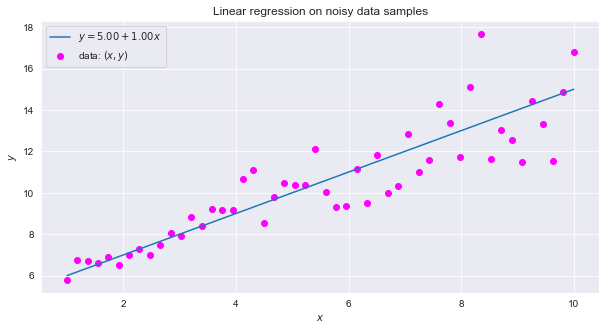

In [538]:
# Definition of the Data
np.random.seed()
# Generate random data
n = 50 # Number of samples
# Underlying linear relation for y = mx+b (linear equation) (Ground truth)
m = 1  # the coefficient of variable x (slope) (m) --> theta_1
b = 5  # the intercept of the model (bias) (b)     --> theta_0
# Noise
noise = 0.2  # Standard deviation of the noise

# Features and output
#x = np.random.uniform(-1, 1, n).astype(np.float32)  # Independent variable x
x = np.linspace(1,10,n, dtype=np.float32)
#x = np.linspace(0, 1, n) 
y = f(x,b, m, noise)           # the dependent (output) variable of sample i, with y={yi…yn}. 



# x = np.linspace(1,10,2*n, dtype=np.float32).reshape(2*n,1)
# y = np.asarray(np.random.normal(m*x[:,0]+b,np.abs(x[:,0])/3.5), dtype=np.float32)

# Stack X with ones to be fitted by vectorized methods
#  such as OLS and gradient descent
X = np.vstack((np.ones_like(x), x)).T


# Show data
plot_linear_regression(x,y,b,m,"Linear regression on noisy data samples")


### Linear regression from a probabilistic view

An alternative description is the [probabilistic](https://en.wikipedia.org/wiki/Bayesian_inference) description of the linear regression problem where we treat the dependent variable $y$ as randomly sampled from a normal distribution with a mean $\mu$ represented by the independent variable $x$ and random variables $\theta$.

$$
y_i \sim \mathcal{N}(\theta_0 + \theta_1 x_i, \sigma^2) \quad (i = 1, \ldots, n)
$$

Note that the mean $\mu = \theta_0 + \theta_1 x$. Given the definition of the [probability densitity](https://en.wikipedia.org/wiki/Probability_density_function) of the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) we can write this as:

$$
p(y_i \mid \theta_0 + \theta_1 x_i, \sigma^2) = 
\frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{(y_i - (\theta_0 + \theta_1 x_i))^2}{2\sigma^2}\right)}
$$

Given the observed data $(x, y)$ and ignoring $\sigma^2$ we can then model the parameters $\theta$ as a density function which we can split up according to the [Bayes rule](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$
p(\theta \mid y, x) = \frac{p(y \mid x, \theta)p(\theta)}{p(y \mid x)}
$$

With:
- $P(\theta \mid y, x)$ the [posterior](https://en.wikipedia.org/wiki/Posterior_probability) density which is our belief of parameters $\theta$ after taking the observed data $(x, y)$ into account.
- $p(y \mid x, \theta)$ is the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) function which is the probability density of the normal distribution $y \sim \mathcal{N}(\theta_0 + \theta_1 x, \sigma^2)$ described above.
- $p(\theta)$ is the [prior](https://en.wikipedia.org/wiki/Prior_probability) density of $\theta$, which captures our belief about parameters $\theta$ before we observed any data. Note that we assume that $\theta$ is independent of $x$ and that $p(\theta \mid x) = p(\theta)$.
- $p(y \mid x)$ is the [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood) of the data where $\theta$ has been [marginalized out](https://en.wikipedia.org/wiki/Marginal_distribution) according to $p(y \mid x) = \int_{\theta} p(y \mid x, \theta) p(\theta) d\theta$.


In Bayesian probability theory, if the posterior distributions $P(\theta \mid y, x)$ are in the same probability distribution family as the prior probability distribution $p(\theta)$, the prior and posterior are then called [conjugate distributions](https://en.wikipedia.org/wiki/Conjugate_prior), and the prior is called a conjugate prior for the likelihood function. If the likelihood function is Gaussian, choosing a Gaussian prior over the mean will ensure that the posterior distribution is also Gaussian. This means that the Gaussian distribution is a conjugate prior for the likelihood that is also Gaussian.

For example, the normal distribution is conjugate to itself, because if the likelihood and prior are normal, then so is the posterior.

Note that the error $\epsilon$ is implicitly captured in this model by treating $y$ as sampled from a normal distribution parametrized by $x$ and $\theta$. In what follows we will also ignore fitting of the variance term $\sigma^2$ for practical purposes.

### Maximum a posteriori estimation (MAP)

We can find a [point estimate](https://en.wikipedia.org/wiki/Point_estimation) $\hat{\theta}$ to fit our parameters $\theta$ by finding the maximum of the posterior distribution $p(\theta \mid y, x)$:

$$
\hat{\theta} = \underset{\theta}{\text{argmax}}\;p(\theta \mid y, x) 
= \underset{\theta}{\text{argmax}}\; \frac{p(y \mid x, \theta)p(\theta)}{p(y \mid x)}
$$

This can be simplified this since the marginal likelihood $p(y \mid x)$ is independent of the parameters $\theta$, and thus won't have an effect on $\hat{\theta}$ corresponding to the maximum of the posterior.

The consequence of discarding ${p(y \mid x)}$ is that now the density $p(\theta \mid y, x)$ has lost some properties like integration to 1 over the domain of $\theta$. This is not a big deal since one is usually not interested in integrating likelihood functions, but in maximizing them:

$$
\hat{\theta} = \underset{\theta}{\text{argmax}}\;p(\theta \mid y, x) 
= \underset{\theta}{\text{argmax}}\; p(y \mid x, \theta)p(\theta)
$$

This is also known as [maximum a posteriori (MAP)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) estimate. In practice most methods to fit the parameters $\theta$ will try to avoid computing the marginal likelihood $p(y \mid x)$, which can be computational expensive due to the integral.

### Maximum likelihood estimation (MLE)

Deviating from the Bayesian perspective, some of the models will ignore the prior $p(\theta)$ for simplicity. They will be treating $p(\theta)$ as an uninformative and [improper](https://en.wikipedia.org/wiki/Prior_probability#Improper_priors) prior:

$$
\hat{\theta} = \underset{\theta}{\text{argmax}}\;p(\theta \mid y, x) \approx \underset{\theta}{\text{argmax}}\; p(y \mid x, \theta)
$$

The resulting optimization is what is known as [maximum likelihood estimation (MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), which will focus only on the [likelihood function](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) $p(y \mid x, \theta)$ while ignoring the prior and marginal term completely.

In our regression example if we assume that all samples $y_i, x_i$ are taken independently from the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) $y_i \sim \mathcal{N}(\theta_0 + \theta_1 x_i, \sigma^2)$ we can write the likelihood function based on the definition of the normal distribution's density function as was [mentioned before](#Bayesian-description):

$$
p(y \mid x, \theta_0, \theta_1) = \prod_{i=1}^{n} p(y_i \mid x_i, \theta_0, \theta_1) = 
\prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{(y_i - (\theta_0 + \theta_1 x_i))^2}{2\sigma^2}\right)}
$$


## 1. Simple linear regression

Given the density function above we can find the estimated parameters $\hat{\theta}_0$ and $\hat{\theta}_1$ corresponding to the maximum of the likelihood function $p(y \mid x, \theta_0, \theta_1)$.

Because the exponents of the density function are difficult to work with and can be numerically unstable we will transform the function with a [logarithmic function](https://en.wikipedia.org/wiki/Log_probability) which is [strictly increasing](https://en.wikipedia.org/wiki/Monotonic_function) and will thus not affect the maxima of the original likelihood function. We call the resulting function the [log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood):

$$
\log(\prod_{i=1}^{n} p(y_i \mid x_i, \theta_0, \theta_1)) = n(1 - \log(\sqrt{2\pi\sigma^2}) - \frac{1}{2\sigma^2} \left[ \sum_{i=1}^{n} (y_i - (\theta_0 + \theta_1 x_i))^2 \right]
$$

We can then find the [maximum](https://en.wikipedia.org/wiki/Maxima_and_minima) for this function by finding where the [derivative](https://en.wikipedia.org/wiki/Derivative) of this function with respect to its parameters becomes 0. If we solve this for our parameters we find that:

$$\begin{align}
\hat{\theta}_1 &= \frac{Cov(x,y)}{Var(x)}\\
&= \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n}(x_i - \bar{x})^2} \\
\hat{\theta}_0 &= \bar{y} - \hat{\theta}_1 \bar{x}
\end{align}$$

with $\bar{y}$ the mean of all dependent variables $y$ and $\bar{x}$ the mean of all independent variables $x$. We can easily implement this as:

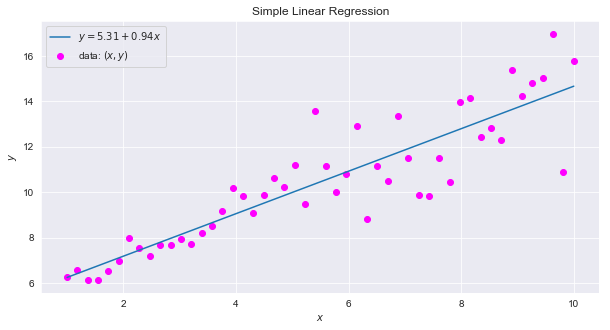

In [4]:
# Simple linear regression
# Compute mean
x_mean = np.mean(x)
y_mean = np.mean(y)

# Compute parameters according to simple linear regression
cov =  ((x-x_mean) * (y-y_mean)).sum()
var = ((x-x_mean)**2).sum()

theta_1 = (cov / var)
theta_0 = y_mean - theta_1 * x_mean

# Show data
plot_linear_regression(x,y,theta_0,theta_1,"Simple Linear Regression")

## 2. Ordinary least squares regression

Note that in the simple linear regression formulation above we end up maximising the log-likelihood which has the term $- \sum_{i=1}^{n} (y_i - (\theta_0 + \theta_1 x_i))^2$. This would be the same as minimizing the negative of this term. We can simplify this solution and make it more general by [vectorizing](https://en.wikipedia.org/wiki/Linear_algebra) our variables and data:

- $\Theta = [ \theta_0, \theta_1]$
- $X = [(1, x_1), \ldots , (1, x_n)]$
- $Y = [y_1, \ldots, y_n]$

Our optimization problem then becomes: 

$$
\hat{\Theta} = \underset{\Theta}{\text{argmin}}{\; \left\Vert Y-X\Theta \right\Vert^2}
$$

This is what is typically known as [ordinary least squares (OLS)](https://en.wikipedia.org/wiki/Ordinary_least_squares) since we are finding the solution with the least deviance in the square of the residuals (error), which is also known as [least squares](https://en.wikipedia.org/wiki/Least_squares). Note that in our example minimizing the least squares is the same as maximizing the likelihood (MLE).

We can solve this by setting the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) (derivative) of $\left\Vert Y-X\Theta \right\Vert^2$ with respect to $\Theta$ to 0:

$$
\frac{\delta \left\Vert Y-X\Theta \right\Vert^2}{\delta \Theta} = -2X^{\top} (Y - X\Theta) = 0
$$

When we drop the $-2$ by multiplying this into the $0$ this gives us $X^{\top}X\hat{\Theta} = X^{\top}Y$, which leads us to the following solution:

$$
\hat{\Theta} = (X^{\top} X)^{-1} X^{\top} Y
$$

With $(X^{\top} X)^{-1} X^{\top}$ the [Moore-Penrose pseude-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of $X$.

The OLS method leads to more advanced regression methods such as [polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression). The OLS fitting example on our linear toy data is implemented below:

Hint: [Vectorized implementation in Machine Learning](https://towardsdatascience.com/vectorization-implementation-in-machine-learning-ca652920c55d) with [numpy arrays](https://webcourses.ucf.edu/courses/1249560/pages/python-lists-vs-numpy-arrays-what-is-the-difference) is very powerful much faster than looping over data. time complexity of vectorization method is $O(s)$, where $s$ in the number of iterations. As contrast, the for loop approach time complexity is $O(s*m*n*m)$, where s is the iterations, n is the dataset sample number, m is the dataset feature number.

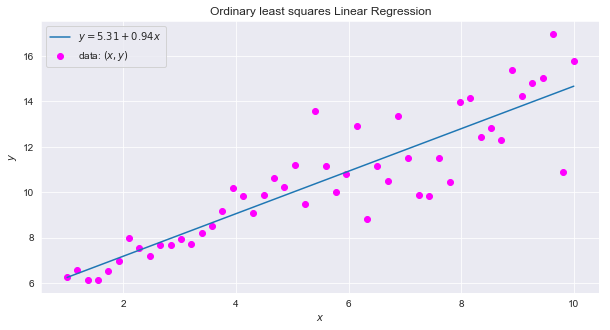

In [5]:
# Ordinary least squares
# Fit parameters with OLS
Theta = np.linalg.inv(X.T @ X) @ X.T @ y

# Show data
plot_linear_regression(x,y,theta_0,theta_1,"Ordinary least squares Linear Regression")

## 3. Gradient descent optimization

OLS assumes a unique solution to the least squares maximisation problem and will not work in more complex non-linear regression methods such as neural networks where our optimization surface is not [convex](https://en.wikipedia.org/wiki/Convex_function) anymore. In this case we can resort to [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) to optimize the loss function.

Next we'll show how to optimize our parameters with regular [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) which can be made stochastic by breaking it down in random batches of size $m < n$.

We're optimizing the same [loss function](https://en.wikipedia.org/wiki/Loss_function) as in OLS, which means we're maximizing the log-likelihood:

$$
\hat{\Theta}  = \underset{\Theta}{\text{argmax}}\log \left( p(Y \mid X, \Theta) \right) = \underset{\Theta}{\text{argmin}}{\; \left\Vert Y-X\Theta \right\Vert^2}
$$

Now because we want to minimize this loss function we can just take small steps towards the [minimum](https://en.wikipedia.org/wiki/Maxima_and_minima) of this function, which lies in the oposite direction of the gradient. We saw that the [gradient](https://en.wikipedia.org/wiki/Gradient) (Jacobian, or derivative) of this loss function was:

$$
\frac{\delta \text{loss}}{\delta \Theta}  = \frac{\delta \left\Vert Y-X\Theta \right\Vert^2}{\delta \Theta} = -2X^T (Y - X\Theta)
$$

This means that if we start out with random parameters $\hat{\Theta}(0)$ we can update these parameters each iteration in the oposite direction of the gradient. Because our loss function is [convex](https://en.wikipedia.org/wiki/Convex_function) in this simple example we should end up at the minimum of our function after a certain amount of steps. One thing we have to make sure that the steps that we take are not to big so that we are not "stepping over" the minimum of our function. We introduce a learning rate parameter $\eta = 0.01$ to prevent this from happening. The parameter update for each iteration $k$ becomes:

$$
\hat{\Theta}(k+1) = \hat{\Theta}(k) - \eta \frac{\delta \text{loss}}{\delta \Theta(k)}
$$

The learning rate $\eta$ is an important parameter that needs to be carefully tuned. If it's too large the solution might never converge, if it's too small the convergence will take a lot of iterations. Thus, in this implementation we adapted the learning rate $\eta$ to $\eta/{adapt}$ if $\vert\delta \text{loss}_i\vert > \vert\delta \text{loss}_{i-1}\vert$

Note that in this case the gradient descent optimizer acts as a maximum likelihood estimator (MLE). Gradient descent and it's variants can be used to optimize complex neural network functions [[1, 2](#Further-readings)]. A simple implementation of gradient descent is provided below.

In [6]:
# Gradient descent
def gradient_descent(X,y, Theta,lr=0.01, numIterations=100,prec=1e-6,adapt=0.5):
    """Gradient descent function"""
    # loss/risk function was theta_head||y-X*theta||^2
    # derivative/jacobian of loss function with respect to theta is -2X^T(y-X*theta)
    losses = []  # Will hold the loss (cost) per iteration
    params = []  # Will hold the theta params per iteration
    x_transpose = X.transpose() # do that once at start
    J_prev = None
    for i in tqdm.tqdm(range(numIterations)):
        # np.dot is the same as @
        #grad = (-2) * X.T.dot((y-(X.dot(theta))))  # gradient
        hypothesis = X @ Theta          # compute hypothesis 
        loss = y - hypothesis           # compute loss
        grad = -2 * x_transpose @ loss  # compute gradient
        Theta -= lr * grad              # update parameters

        J = np.mean(loss**2)            # MSE loss
        losses.append(J)
        params.append(Theta.copy())
        # if(i%10 == 0):
        #     print(f'iteration:{i} loss:{J:.5f} lr:{lr:.5f}')

        # Adapt learning rate to handle convergence (also possible to break here "early stopping")
        if(i>0):
            if(abs(abs(losses[i]) > abs(losses[i-1]))): 
                lr *=adapt # percentage adaption of the learning rate
                #print(f'iteration:{i} loss:{J:.5f} lr:{lr:.5f} -- adapt lr')
        if J_prev is not None:
            if(np.isclose(J,J_prev,rtol=prec)):
                print(f'Converge after {i}')
                break
        J_prev = J

    return Theta,losses,params


In [7]:
# Implementation of gradient descent
# Random initial parameters
np.random.seed(42)
Theta = np.random.randn(2)
learning_rate = 0.001  # Learning rate
num_Iterations = 1000   # Number of max iterations
adaption_rate = 0.5     # percentage of current learning rate adaption

# calculate theta and loss with gradient_descent
Theta, loss_hist, param_hist = gradient_descent(X,y,Theta.copy(), lr=learning_rate,numIterations=num_Iterations,adapt=0.5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 15871.04it/s]


In [8]:
def plot_gradient_descent(X,y,Theta,param_hist,ax=None):
    # Show loss surface
    nb_of_ws = X.shape[0] # compute the loss nb_of_ws times in each dimension
    amax = int(np.max(param_hist[0:])*2)
    bmax = int(np.max(param_hist[1:])*2)
    wsa = np.linspace(-amax, amax, num=nb_of_ws) # theta_0
    wsb = np.linspace(-bmax, bmax, num=nb_of_ws) # theta_1
    ws_x, ws_y = np.meshgrid(wsa, wsb) # generate grid
    loss_ws = np.zeros((nb_of_ws, nb_of_ws)) # initialize loss matrix
    # Fill the loss matrix for each combination of weights
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            theta = np.asarray([ws_x[i,j], ws_y[i,j]])
            loss_ws[i,j] = np.mean((y - (X @ theta))**2)
    # Plot the loss function surface
    cont = ax.contourf(ws_x, ws_y, loss_ws, 20, cmap=cm.viridis)
    # Plot the parameter updates
    theta_prev = None
    for theta in param_hist: 
        # Plot the param-loss values that represents the update
        ax.scatter([theta[0]], [theta[1]], color='w', s=2)
        if theta_prev is not None:
            ax.plot(
                [theta_prev[0], theta[0]], 
                [theta_prev[1], theta[1]], 'w-')
        if((theta_prev == theta).all()): break
        theta_prev = theta
    # Plot final parameter
    ax.scatter(
        [Theta[0]], [Theta[1]], label='Final parameter $\\hat{\\Theta}$',
        color='w', marker='*', s=150, edgecolors='k')
    cbar = plt.colorbar(cont)
    cbar.set_label('X+Y')
    cbar.ax.set_ylabel(
        '$\\left\\Vert Y-X\\Theta \\right\\Vert^2$', fontsize=12)
    ax.set_title((
        '$\\Theta(k)$ updates on loss surface '
        '$\\left\\Vert Y-X\\Theta \\right\\Vert^2$'))
    ax.set_xlabel('$\\Theta_0$')
    ax.set_ylabel('$\\Theta_1$')
    ax.legend()
    
def plot_loss(loss,ax):
    ax.set_ylabel('J($\Theta$)',rotation=0)
    ax.set_xlabel('Iterations')
    ax.plot(loss,'r.')

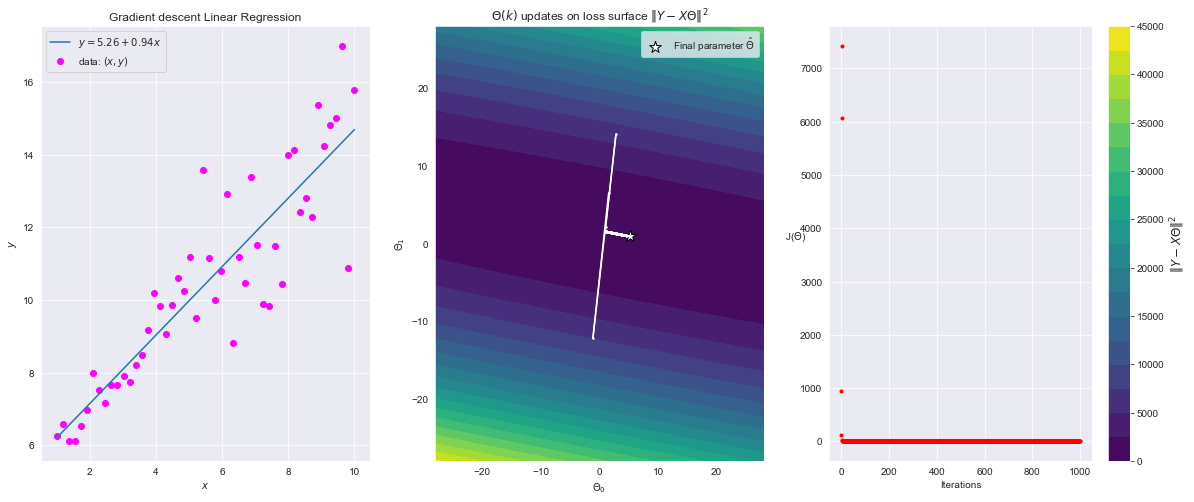

In [9]:
# Show data
fig, gdax= plt.subplots(1, 3, figsize=(20, 8))

plot_linear_regression(x,y,Theta[0],Theta[1],"Gradient descent Linear Regression",gdax[0])
plot_gradient_descent(X,y,Theta,param_hist,gdax[1])
plot_loss(loss_hist,gdax[2])

## 4. Markov Chain Monte Carlo parameter estimation

An alternative to optimizing the likelihood function is to [approximate](https://en.wikipedia.org/wiki/Approximate_Bayesian_computation) the full posterior by sampling based on [Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methods. One such sampling algorithm is the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm) which allows us to sample from the posterior $p(\theta \mid y, x)$. A very nice explaination of this algorithm is given [here](https://www.youtube.com/watch?v=OTO1DygELpY).

Remember that the posterior density of $\theta$ given the observed data $x, y$ is defined as:

$$
p(\theta \mid y, x) = \frac{p(y \mid x, \theta)p(\theta)}{p(y \mid x)}
$$


### Sampling with Metropolis-Hastings

The Metropolis-Hasting algorithm defines a way to create a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) which has as [stationary distribution](https://en.wikipedia.org/wiki/Stationary_distribution) the posterior $p(\theta \mid y, x)$ we're trying to approximate. What this means is that if we sample infinite number of samples from this markov chain the samples should be as if they were sampled from the posterior.

Given an initial guess for parameters $\theta(0)$, the Metropolis-Hastings algorithm works as follows
1. Propose a new parameter value $\theta_p$ by adding random noise to the the initial parameters: 

$$
\theta_{p}(k) = \theta(k) + \Delta \theta \quad \text{with}\; \Delta \theta \sim \mathcal{N}(0, \sigma^2)
$$

2. Find out how much more likely the new proposed parameter $\theta_{p}(k)$ is with respect to the previous parameter $\theta(k)$ by calculating the ratio: 

$$
r = \frac{p(\theta_p \mid y, x)}{p(\theta \mid y, x)} 
= \frac{\frac{p(y \mid x, \theta_p) p(\theta_p)}{p(y \mid x)}}{\frac{p(y \mid x, \theta)p(\theta)}{p(y \mid x)}} 
=\frac{p(y \mid x, \theta_p)p(\theta_p)}{p(y\mid x, \theta)p(\theta)}
$$

3. Then accept the proposal $\theta_{p}(k)$ as the new parameter $\theta(k+1)$ if the ratio $r\geq 1$, or if $r \lt 1$ accept $\theta_{p}(k)$ as new parameter with probability $r$. If not accepted keep $\theta(k+1)=\theta(k)$.

4. To keep sampling repeat from step 1.

For comparison we will do the calculation ignoring the prior $p(\theta)$ below and treating it as an [improper prior](https://en.wikipedia.org/wiki/Prior_probability#Improper_priors) when calculating the ratio $r$ and we will do the calculation assuming a normal distributed prior.

$$
r = \frac{p(y \mid x, \theta_p)}{p(y \mid x, \theta)}, r=\frac{p(y \mid x, \theta_p)p(\theta_p)}{p(y\mid x, \theta)p(\theta)}
$$

If we want to add a specific prior this should be relatively simple and we shoud just multiply an extra term when calculating the ratio $r$. We will thus only use the ratio of the likelihood functions. We defined this likelhood function for our problem [earlier](#Bayesian-description) as:

$$
p(y \mid x, \theta_0, \theta_1) = \prod_{i=1}^{n} p(y_i \mid x_i, \theta_0, \theta_1) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{(y_i - (\theta_0 + \theta_1 x_i))^2}{2\sigma^2}\right)}
$$

To avoid [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) when probabilities are small we will be performing the computations in the [log](https://en.wikipedia.org/wiki/Log_probability) space where the multiplications will become additions.


###  Parameter estimation

After sampling we can find best point estimates of the parameter by [Bayesian estimation](https://en.wikipedia.org/wiki/Bayes_estimator) by taking the [expected value](https://en.wikipedia.org/wiki/Expected_value) ([mean](https://en.wikipedia.org/wiki/Arithmetic_mean)) of the sampled parameters. In practice we only compute the mean over the last samples because MCMC needs the first steps to converge towards the stationary distribution. A simple implementation on our toy data is provided below.

MCMC might be overkill for our simple toy problem, however, it can be used to approximate the posterior of complex distributions such as [multilevel models](https://docs.pymc.io/notebooks/multilevel_modeling.html). 

In [10]:
def log_prior(theta,sigma=0.1):
    """Log-prior function. We assume that theta is normal distributed with fixed sigma 
    (maybe this could be changed into a non negative sigma)"""
    
    if sigma <=0 or sigma > 0.1:
        return 0
    
    theta_0_prior = np.random.normal(theta[0],sigma)
    theta_1_prior = np.random.normal(theta[1],sigma)
    # log probability transforms multiplication to summation
    return np.log(theta_0_prior) + np.log(theta_1_prior)


def log_likelihood(x,y,theta,sigma):
    """Log-likelihood function."""
    # number of elements
    n=len(y) 
    variance = sigma**2
    # sum of squared errors
    sse = sum((y-(theta[0]+theta[1]*x))**2)
    return -((0.5*n) * log(2*pi)) \
           -((0.5*n) * log(variance)) \
           -(sse /(2 * variance))

                        
def metropolis_hastings(x,y, theta, sigma,numIterations,with_prior=True):
    """Metropolis-hastings function, each iteration explains one MCMC Metropolis Hastings step."""
    accepted = []  # List of accepted samples
    rejected = []  # List of accepted samples
    for _ in tqdm.tqdm(range(numIterations)):
        # Run until new proposed sample has been accepted
        while True:  
            # Propose a new parameter values by adding some noise (sigma * random + mu)
            theta_p = 0.1 *  np.random.randn(2) + theta
            sigma_p = 0.1 *  np.random.randn(1) + sigma   
            
            if with_prior == True:
                # calculate the ratio r - because it is the log (see log rules)  
                r = (
                    (log_likelihood(x,y, theta_p, sigma_p)+log_prior(theta_p,sigma_p)) - 
                    (log_likelihood(x,y, theta, sigma))+log_prior(theta,sigma))
            else:
                r = (
                    log_likelihood(x,y, theta_p, sigma_p) - 
                    log_likelihood(x,y, theta, sigma))
            if r >= e:
                # Ratio >= 1: accept proposal
                theta,sigma = theta_p, sigma_p
                break
                
            elif log(np.random.uniform()) < r:
                # Ratio < 1: check with probability == ratio
                theta,sigma = theta_p, sigma_p
                break
            else:
                # save rejected value and find new one
                rejected.append((theta_p,sigma_p))
                
            # if break accept the value        
            accepted.append((theta,sigma))
        
    # return all accepted and rejected values    
    return np.array(accepted),np.array(rejected)

In [11]:
# Implementation of metropolis-Hasting MCMC
np.random.seed(123) # Use same seed for reproducability

# Initial guess of the parameters
Theta_init = np.array([1.,1.]).astype(np.float32)
sigma_init = 1.
num_iter = 3000
burn_in_samples = num_iter//4 # 

# Run Metropolis-Hastings MCMC
accepted_p, rejected_p = metropolis_hastings(x,y,Theta_init,sigma_init,num_iter,with_prior=False)


# split the samples
theta_samples, sigma_samples = zip(*accepted_p)
theta_samples_rej, sigma_samples_rej = zip(*rejected_p)
theta_samples = np.vstack(theta_samples)
theta_samples_rej = np.vstack(theta_samples_rej)
sigma_samples = np.vstack(sigma_samples)
sigma_samples_rej = np.vstack(sigma_samples_rej)

# Compute the expected value of the last samples
# The first n samples are ignored because the MCMC has not yet converged (BURN-IN Phase)
Theta_ = theta_samples.mean(axis=0)
Theta = theta_samples[burn_in_samples:].mean(axis=0)
print(f' Theta with burn in phase: {Theta}')
print(f' Theta without burn in phase: {Theta_}')
print(f' Diff: {Theta-Theta_}')
#print(theta_samples[burn_in_samples:].mean(axis=0)[0])
#print((np.mean(theta_samples[:,1][burn_in_samples:]))) ## Theta 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 5221.27it/s]


 Theta with burn in phase: [5.38166125 0.92476856]
 Theta without burn in phase: [5.32511489 0.93283842]
 Diff: [ 0.05654635 -0.00806986]


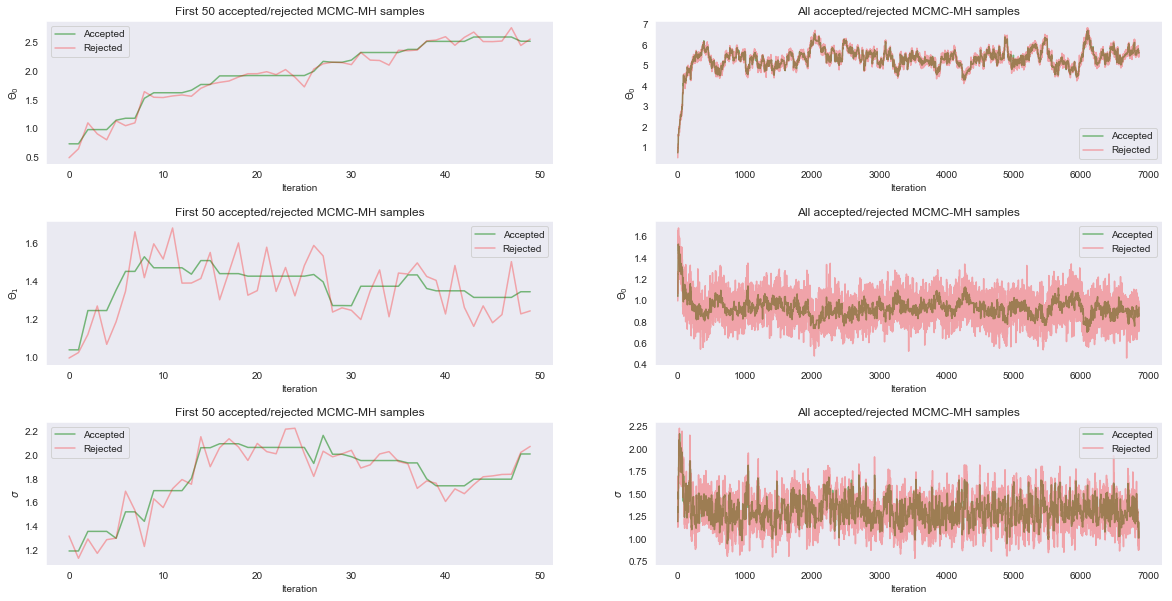

In [12]:
def plot_MCMC_MH_samples(samples_acc,samples_rej=None,label=None, title=None,ax=None):
    ax.plot( samples_acc, 'g-', label='Accepted',alpha=0.5)
    if samples_rej is not None:
        ax.plot( samples_rej, 'r-', label='Rejected',alpha=0.3)
    ax.set_xlabel("Iteration")
    ax.set_ylabel(label)
    ax.set_title(title)
    ax.grid()
    ax.legend()

# Show data
fig, ax= plt.subplots(3, 2, figsize=(20, 10))
fig.subplots_adjust(hspace=0.4)
to_show = -theta_samples.shape[0]

plot_MCMC_MH_samples(theta_samples[:,0][0:50],theta_samples_rej[:,0][0:50],"$\Theta_0$","First 50 accepted/rejected MCMC-MH samples",ax[0][0])
plot_MCMC_MH_samples(theta_samples[:,0][to_show:],theta_samples_rej[:,0][to_show:],"$\Theta_0$","All accepted/rejected MCMC-MH samples",ax[0][1])
plot_MCMC_MH_samples(theta_samples[:,1][0:50],theta_samples_rej[:,1][0:50],"$\Theta_1$","First 50 accepted/rejected MCMC-MH samples",ax[1][0])
plot_MCMC_MH_samples(theta_samples[:,1][to_show:],theta_samples_rej[:,1][to_show:],"$\Theta_0$","All accepted/rejected MCMC-MH samples",ax[1][1])
plot_MCMC_MH_samples(sigma_samples[:][0:50],sigma_samples_rej[:][0:50],"$\sigma$","First 50 accepted/rejected MCMC-MH samples",ax[2][0])
plot_MCMC_MH_samples(sigma_samples[:][to_show:],sigma_samples_rej[:][to_show:],"$\sigma$","All accepted/rejected MCMC-MH samples",ax[2][1])

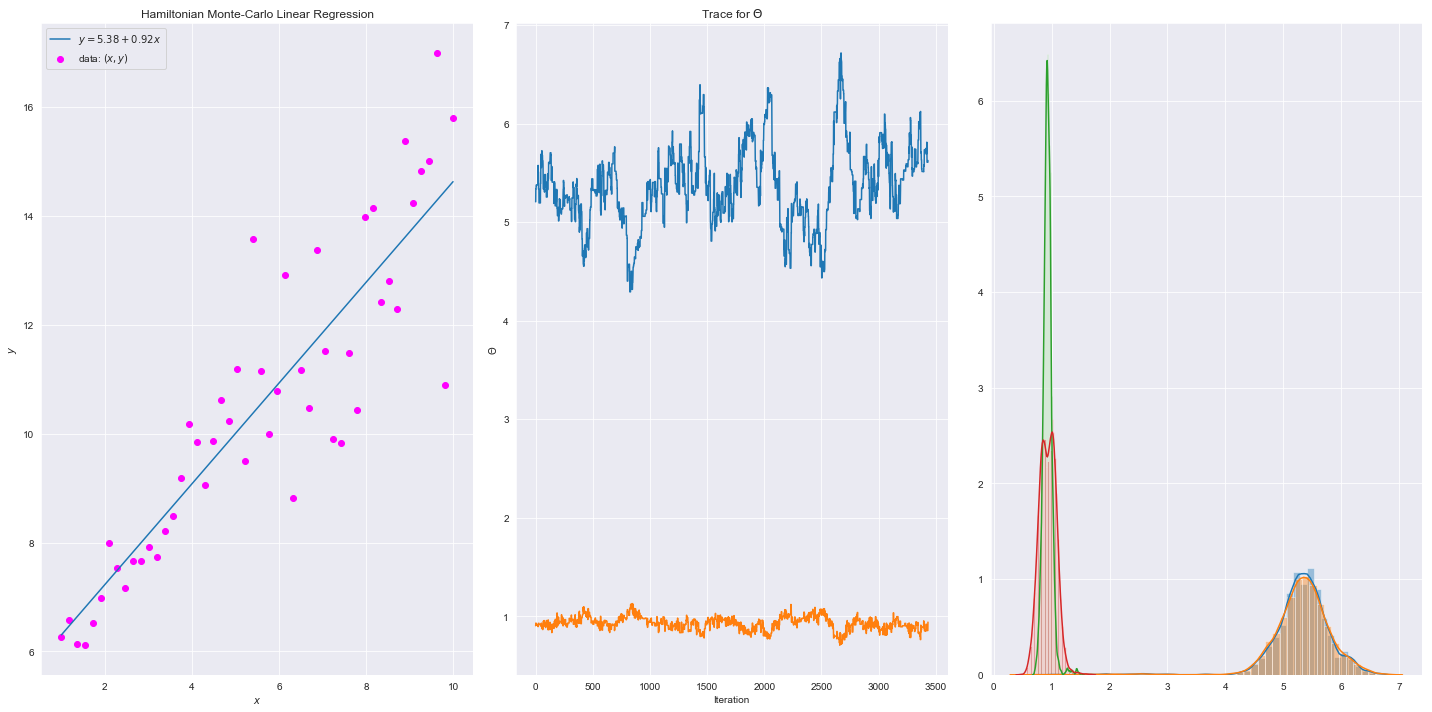

In [13]:
show=int(-0.5*accepted_p.shape[0])
hist_show=int(-0.5*accepted_p.shape[0])

# convert to numpy array otherise the plot of the hist stuck
show_val = np.array(theta_samples[show:])
hist_val = np.array(theta_samples[hist_show:])


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,3,1)
plot_linear_regression(x,y,Theta[0],Theta[1],"Hamiltonian Monte-Carlo Linear Regression",ax)

ax = fig.add_subplot(1,3,2)
ax.plot(show_val)
ax.set_title("Trace for $\Theta$")
ax.set_ylabel("$\Theta$")
ax.set_xlabel("Iteration")

ax = fig.add_subplot(1,3,3)
# ax.hist(hist_val, bins=50,density=True)
# ax.axvline(theta_samples.mean(axis=0)[0], color='g', linestyle='dashed', linewidth=5)
# ax.axvline(theta_samples.mean(axis=0)[1], color='b', linestyle='dashed', linewidth=5)
# ax.set_ylabel("Frequency (normed)")
# ax.set_xlabel("$\Theta$")
# ax.set_title("Histogram of $\Theta$")
# ax.legend([f'$\Theta_0${theta_samples.mean(axis=0)[0]:.5f}',f'$\Theta_1${theta_samples.mean(axis=0)[1]:.5f}'])
sns.distplot(theta_samples[:,0][to_show:], norm_hist=True, kde=True)
sns.distplot(theta_samples_rej[:,0][to_show:], norm_hist=True, kde=True)
sns.distplot(theta_samples[:,1][to_show:], norm_hist=True, kde=True)
sns.distplot(theta_samples_rej[:,1][to_show:], norm_hist=True, kde=True)

fig.tight_layout()

## 5. Linear Regression with Keras and Tensorflow

In this section we want to use [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/) as well as [Tensorflow-Probability](https://www.tensorflow.org/probability) to solve this linear regression task.


### 5.1 Estimate parameters with neural network


Training ------------

Testing ------------
loss:0.029274178445339204
mean_squared_error:0.02927417680621147
mean_absolute_error:0.14018894731998444


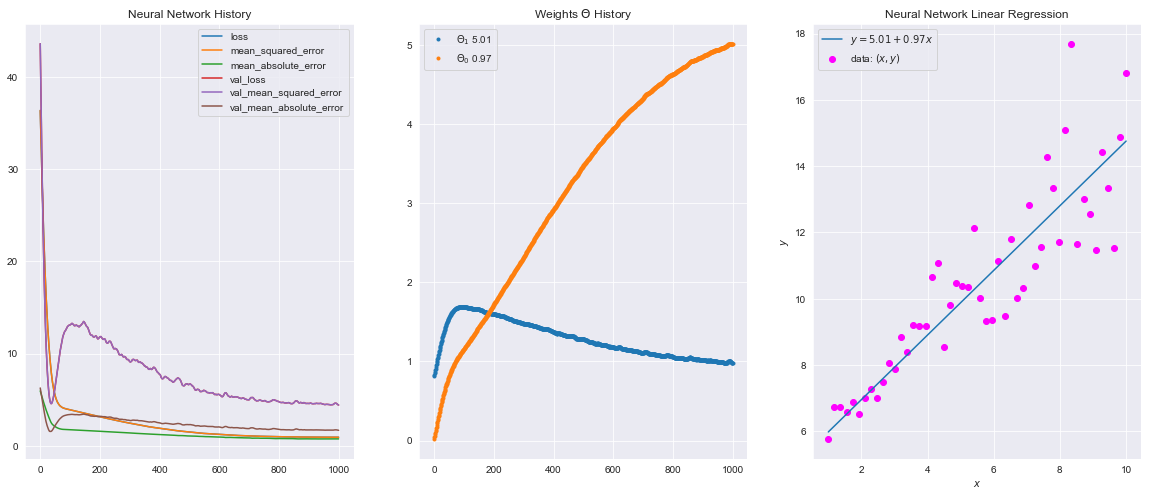

In [539]:
# Import keras model and layers
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers,losses
from tensorflow.keras.callbacks import LambdaCallback,Callback
import tensorflow_probability as tfp

# Enable eager execution for debugging
tf.enable_eager_execution()

K.clear_session()



# Split train,val,test
split=int(0.8*x.shape[0])
X_train, Y_train = x[:split], y[:split]     
X_val, Y_val = x[split:], y[split:] 

#Generate some testdata
X_test = np.linspace(min(x)-3,max(x)+3, num=x.shape[0],dtype=np.float32)
Y_test = f(X_test,b, m, 0.0)


def findBatchSize(TrainInputSize):
    ''' Find correct batch size'''
    for i in range(10):
        if(2**i > TrainInputSize):
            return 2**(i-1)


#Define the model
def baseline_model():
    NN_model = Sequential()
    NN_model.add(Dense(1,input_shape=(1,), activation='linear'))
    sgd = optimizers.SGD(lr=0.01)
    adam = optimizers.Adam(lr=0.01)
    #NN_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    NN_model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse', 'mae'])

    return NN_model

# Example how the Test Data can be checked besides the train data per epoch
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        #loss, acc = self.model.evaluate(x, y, verbose=0)
        print(f'lalalala: {self.model.metrics_names}')
        #print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
           

# Build a neural network from 1st layer to the last layer
#model = Sequential()
#model.add(Dense(1, input_shape=(1,)))

# Choose loss function and optimizing method
# mse = mean squared error
# sgd = stochastic gradient descent
#model.compile(loss='mse', optimizer=sgd)

weights = []
log_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: weights.append(model.layers[0].get_weights()))

#Create the model
model = baseline_model()
#print(model.summary())
#print(f'calculated batch size {findBatchSize(min(X_train.shape[0],X_test.shape[0]))}')

print('\nTraining ------------')
history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_val,Y_val),
                    epochs=1000,
                    verbose=0,
                    batch_size=findBatchSize(min(X_train.shape[0],X_test.shape[0])),
                    callbacks=[log_weights])
                    #callbacks=[log_weights,TestCallback((X_test, Y_test))])

# Store the weights
weights = np.array(weights).reshape(-1,2)
Theta = np.squeeze(model.get_layer("dense").get_weights())

# Show history and weights per epoch
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,3,1)
for key in history.history:
    ax.plot(history.history[key],label=key)
    ax.set_title("Neural Network History")
plt.legend()
    
ax = fig.add_subplot(1,3,2)
ax.plot(weights,'.')
ax.set_title("Weights $\Theta$ History")
ax.legend([f'$\Theta_1$ {Theta[1]:.2f}',f'$\Theta_0$ {Theta[0]:.2f}'])

ax = fig.add_subplot(1,3,3)
plot_linear_regression(x,y,Theta[1],Theta[0],"Neural Network Linear Regression",ax)


# # #Training
# # print('Training -----------')
# # for step in range(5000):
# #     cost = model.train_on_batch(X_train, Y_train)
# #     if step % 100 == 0:
# #         print('train cost: ', cost)


print('\nTesting ------------')
scores = model.evaluate(X_test,Y_test,batch_size=findBatchSize(min(X_train.shape[0],X_test.shape[0])),verbose=0)

for i in range(len(scores)):
    print(f'{model.metrics_names[i]}:{scores[i]}')


# pred = model.predict(X_test,batch_size=findBatchSize(min(X_train.shape[0],X_test.shape[0])))

# print(losses.mean_squared_error(Y_test,pred.T))

#tf.print(losses.mean_squared_error(Y_test,pred))
# print(Y_test)
# print(np.squeeze(pred))
# print(Y_test-pred.T)
#print(f'{model.metrics_names}{scores}')
#print(model.metrics_names)
# theta_1, theta_0 = model.layers[0].get_weights()
# print('Theta_0=', theta_0, '\nTheta_1=', theta_1)

### 5.2 Estimate parameters with neural network and Tensorflow Probability

Functional API

Training ------------
[0.9561963 5.2458625]

Testing ------------


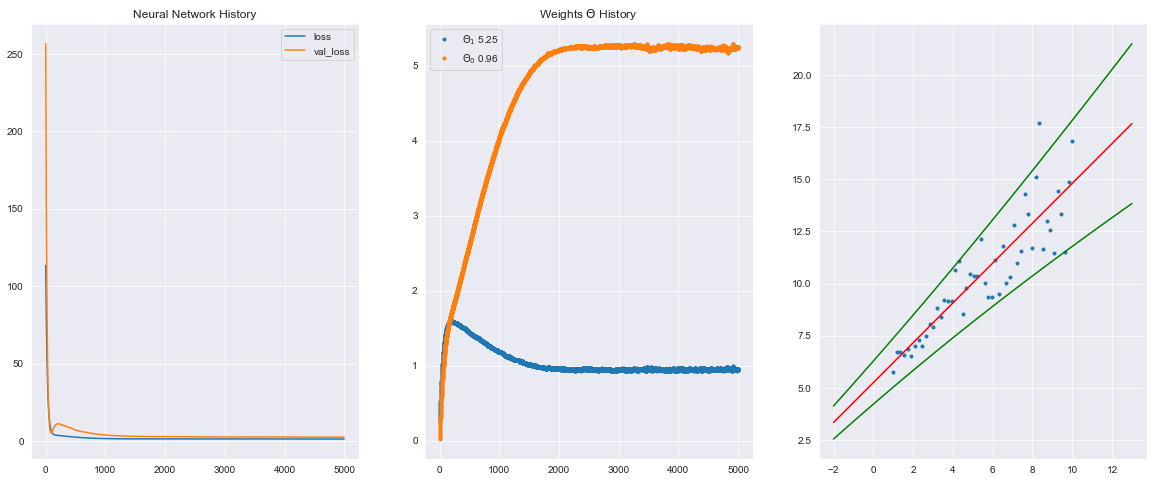

In [542]:
# https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf

# Set Tensorflow Distribution
tfd = tfp.distributions

# Define Negative Log-Likelyhood
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
# Clear current Keras session
tf.keras.backend.clear_session()

#Define the model without functional API 
def baseline_model_tfp():
    # Build model without functinal API
    NN_model = tf.keras.Sequential([
      tf.keras.layers.Dense(1+1,input_shape=(1,)),
      #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
      tfp.layers.DistributionLambda(
                           lambda t: tfd.Normal(loc=t[..., :1], # mu :1
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))), # sigma :2
    ])
    return NN_model


# Define the model with functional API (more flexible than keras.Sequential)
# https://www.tensorflow.org/alpha/guide/keras/functional
inputs = tf.keras.Input(shape=(1,))
t = tf.keras.layers.Dense(1+1)(inputs) 
p_y =tfp.layers.DistributionLambda(
                           lambda t: tfd.Normal(
                               loc=t[..., :1], # mu :1
                               scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))# sigma :2
                                )(t)

if True:
    model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
    print("Functional API")
else:
    model = baseline_model_tfp()
    print("Without Functional API")

weights = []
log_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: weights.append(model.layers[1].get_weights()))

# Do inference.
model.compile(optimizer=optimizers.Adam(lr=0.01), loss=negloglik)

print('\nTraining ------------')
history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_val,Y_val),
                    epochs=5000,
                    verbose=0,
                    batch_size=findBatchSize(min(X_train.shape[0],X_test.shape[0])),
                    callbacks=[log_weights])
                    #callbacks=[log_weights,TestCallback((X_test, Y_test))])
    

                    

# # Store the weights
#weights = np.array(weights).reshape(-1,2)
weights = np.array([[np.squeeze(a,axis=0),b] for a,b in weights])


# # get the weights
# #w = np.squeeze(model.layers[-2].kernel.numpy())
# #b = np.squeeze(model.layers[-2].bias.numpy())
Theta = np.array([np.squeeze(w.numpy()) for w in model.weights])

Theta = Theta[...,0] # Get the weights only (first column in the (2,2) array)

print(Theta)
# Show history and weights per epoch
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,3,1)
for key in history.history:
    ax.plot(history.history[key],label=key)
    ax.set_title("Neural Network History")
plt.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(weights[...,0],'.')
ax.set_title("Weights $\Theta$ History")
ax.legend([f'$\Theta_1$ {Theta[1]:.2f}',f'$\Theta_0$ {Theta[0]:.2f}'])


print('\nTesting ------------')
x_tst = X_test[..., np.newaxis].astype(np.float32) # ... = Ellipsis https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
yhat = model(x_tst)

mu = yhat.mean().numpy()
sigma = yhat.stddev().numpy() # aleatoric uncertainty


#plot_linear_regression(x,y,Theta[1],Theta[0],"Neural Network Linear Regression TFP")
ax = fig.add_subplot(1,3,3)
ax.plot(x_tst,mu, c='r')
ax.scatter(x,y, marker='.')
ax.plot(x_tst,mu + 2*sigma, c='g')
ax.plot(x_tst,mu - 2*sigma, c='g')


assert isinstance(yhat, tfd.Distribution)


### 5.3 Estimate parameters with Tensorflow Probability and MCMC Metropolis Hastings

In [ ]:
# Log Likelihood shall only be dependent on theta and sigma
def log_likelihood2(theta,sigma):
    """Log-likelihood function."""
    # number of elements
    n=len(y) 
    variance = sigma**2
    # sum of squared errors
    sse = sum((y-(theta[0]+theta[1]*x))**2)
    return -((0.5*n) * log(2*pi)) \
           -((0.5*n) * log(variance)) \
           -(sse /(2 * variance))


# Random Walk Metropolis
print("Random Walk Metropolis")
kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=log_likelihood2,
    seed=42
)

# run sample chain
states, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_iter,
        num_burnin_steps=burn_in_samples,
        current_state = [Theta_init,sigma_init],
        kernel=kernel)

# get the results
Theta_samples,Sigma_samples = states

Theta_samples = np.asarray(Theta_samples)
Sigma_samples = np.asarray(Sigma_samples)

# #plt.plot(states[:][0].numpy())

Theta = tf.reduce_mean(Theta_samples, axis=[0])
Theta_var = tf.reduce_mean(
    tf.squared_difference(Theta_samples, Theta),
    axis=[0])

#Show data
fig, ax= plt.subplots(3, 1, figsize=(20, 10))
fig.subplots_adjust(hspace=0.4)
to_show = -Theta_samples.shape[0]
plot_MCMC_MH_samples(Theta_samples[:,0],None,"$\Theta_0$","All accepted MCMC-MH samples",ax[0])
plot_MCMC_MH_samples(Theta_samples[:,1],None,"$\Theta_0$","All accepted MCMC-MH samples",ax[1])
plot_MCMC_MH_samples(Sigma_samples[:],None,"$\sigma$","All accepted MCMC-MH samples",ax[2])

Random Walk Metropolis


### Kulback-Leibler (Test)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab

from scipy.stats import norm
from scipy.integrate import quad
mu1 = 2
sigma1 = 3
mu2 = 5
sigma2 = 2

def p(x):
    return norm.pdf(x, mu1, sigma1)

def q(x):
    return norm.pdf(x, mu2, sigma2)


def KL(x):
    return p(x) * (np.log(p(x))-np.log(q(x)) )


def KL_2():
    #return -0.5* np.log(sigma1**2)+((sigma1+(mu1-mu2)**2)/(2*sigma2**2))

    return -0.5*(np.log(sigma1**2) - sigma1**2 - mu1**2 + np.log(sigma2**2) - sigma2**2 - mu2**2)-1


# A special case, and a common quantity in variational inference, is the KL-divergence between a 
# diagonal multivariate normal, and a standard normal distribution (only if mu2=0, and sigma2=1):
def KL_NormDist():
    return 0.5*(sigma1**2+mu1**2 -np.log(sigma1**2)-1)


print('KL_NormDist',KL_NormDist())
# print(KL_new())
# print(KL_new2())
range = np.arange(-20, 20, 0.01)

print('KL',KL(range).sum())
print('KL_2',KL_2())
# int_p, err = quad(p, -10, 10) 
# int_q, err = quad(q, -10, 10) 
int_KL, err = quad(KL, -20, 20) 
# print ('int_p: ', int_p)
# print ('int_q: ', int_q)
print ('int_KL: ', int_KL)



plt.plot(range, p(range),label="p")
plt.plot(range, q(range),label="q")
plt.plot(range, KL(range),label="KL")
plt.legend()

## References

TODO

In [ ]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
print('keras: {}'.format(tf.keras.__version__))
print('tensorflow: {}'.format(tf.__version__))
print("tensorflow-probability", tfp.__version__)
#